In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
import tensorflow as tf
import tensorflow_probability as tfp
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
tf.enable_eager_execution()

tfd = tfp.distributions
tfb = tfp.bijectors

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
def print_subclass_from_module(module, base_class, max_width=80):
    import functools, inspect, sys
    subclasses = [name for name, obj in inspect.getmembers(module)
                  if inspect.isclass(obj) and issubclass(obj, base_class)]
    def red(acc, x):
        if not acc or len(acc[-1]) + len(x) + 2 > max_width:
            acc.append(x)
        else:
            acc[-1] += ", " + x
        return acc
    print("\n".join(functools.reduce(red, subclasses, [])))

In [3]:
print_subclass_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchReshape, Bernoulli, Beta, Binomial, Blockwise, Categorical
Cauchy, Chi, Chi2, Chi2WithAbsDf, ConditionalDistribution
ConditionalTransformedDistribution, Deterministic, Dirichlet
DirichletMultinomial, Distribution, Empirical, ExpRelaxedOneHotCategorical
Exponential, FiniteDiscrete, Gamma, GammaGamma, GaussianProcess
GaussianProcessRegressionModel, Geometric, Gumbel, HalfCauchy, HalfNormal
HiddenMarkovModel, Horseshoe, Independent, InverseGamma, InverseGaussian
JointDistribution, JointDistributionCoroutine, JointDistributionNamed
JointDistributionSequential, Kumaraswamy, LKJ, Laplace
LinearGaussianStateSpaceModel, LogNormal, Logistic, Mixture, MixtureSameFamily
Multinomial, MultivariateNormalDiag, MultivariateNormalDiagPlusLowRank
MultivariateNormalDiagWithSoftplusScale, MultivariateNormalFullCovariance
MultivariateNormalLinearOperator, MultivariateNormalTriL
MultivariateStudentTLinearOperator, NegativeBinomial, Normal, OneHotCategorical
Pareto, Poisson, PoissonLogNo

In [4]:
tf.test.gpu_device_name()  # check hardware acceleration

'/device:GPU:0'

In [5]:
# a = tf.constant(np.pi)
# b = tf.constant(np.e)
# with tf.GradientTape() as tape:
#     tape.watch([a, b])
#     c = 0.5 * (a ** 2 + b ** 2)
# grads = tape.gradient(c, [a, b])
# print(grads[0].numpy())
# print(grads[1].numpy())

## 1. Distributions

### A simple scalar-variate Distribution

tfp.distributions.Normal("Normal/", batch_shape=[], event_shape=[], dtype=float32)


Text(0.5, 1.0, 'Samples from a standard normal')

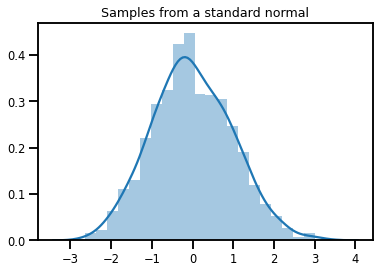

In [6]:
normal = tfd.Normal(loc=0, scale=1.)
print(normal)

samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard normal")

In [7]:
print(normal.log_prob(0.).numpy())
print(normal.log_prob([-1, 0, 1]).numpy())

print(ss.norm(0, 1).logpdf(0))
print(ss.norm(0, 1).logpdf([-1, 0, 1]))

-0.9189385
[-1.4189385 -0.9189385 -1.4189385]
-0.9189385332046727
[-1.41893853 -0.91893853 -1.41893853]


### Distributions and Shapes

In [8]:
normals = tfd.Normal([-2.5, 0, 2.5], 1.)
print(normals.batch_shape)
print(normals.event_shape)

(3,)
()


In [9]:
samples = normals.sample(1000)
print(samples.shape)

samples = normals.sample([10, 10, 100])
print(samples.shape)

(1000, 3)
(10, 10, 100, 3)


In [10]:
print(normals.log_prob([-2.5, 0, 2.5]))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


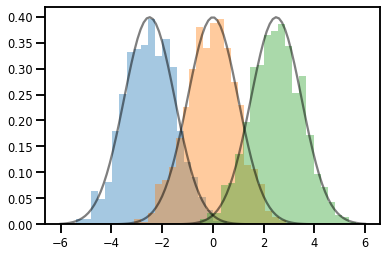

In [11]:
x = np.linspace(-6, 6, 100).reshape(-1, 1)
samples = normals.sample(1000)
for i in range(3):
    sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(x, 3), normals.prob(x), c="k", alpha=0.5)

### A vector-variable `Distribution`

()
(2,)
(1000, 2)


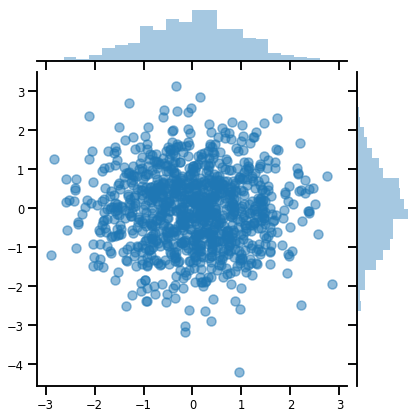

In [12]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
print(mvn.batch_shape)
print(mvn.event_shape)

samples = mvn.sample(1000)
print(samples.shape)


sns.jointplot(samples[:, 0], samples[:, 1], kind="scatter", alpha=0.5)

### A matrix-variate `Distribution`

In [13]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print(lkj.batch_shape)
print(lkj.event_shape)

(2,)
(10, 10)


(1, 2, 10, 10)


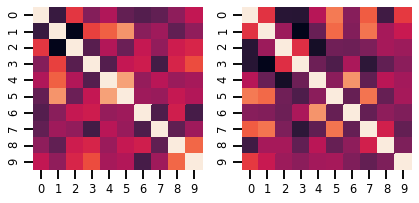

In [14]:
samples = lkj.sample(1)
print(samples.shape)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3))

for i in range(2):
    sns.heatmap(samples[0][i], ax=axes[i], cbar=False)
fig.tight_layout()

### Gaussian Processes

In [15]:
kernel = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic()
x = np.linspace(-5, 5, 200).reshape(-1, 1)
gp = tfd.GaussianProcess(kernel, index_points=x)
print(gp.batch_shape)
print(gp.event_shape)

()
(200,)


Text(0.5, 1.0, 'GP prior mean, $2\\sigma$ intervals and samples')

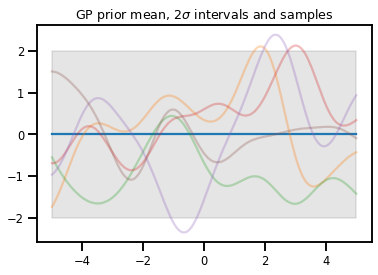

In [16]:
upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(x, gp.mean())
plt.fill_between(x.reshape(-1), lower, upper, color="k", alpha=0.1)
for _ in range(5):
    plt.plot(x, gp.sample(), alpha=0.3)
plt.title(r"GP prior mean, $2\sigma$ intervals and samples")

### GP Regression

In [17]:
obs_x = np.array([-3., 0., 2.]).reshape(-1, 1)
obs_y = np.array([3., -2., 2.])

gprm = tfd.GaussianProcessRegressionModel(kernel, x, obs_x, obs_y)

Text(0.5, 1.0, 'GP posterior mean, $2\\sigma$ intervals and samples')

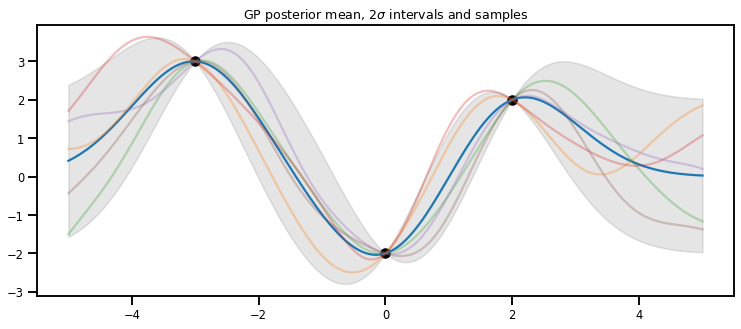

In [18]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.figure(figsize=(12.5, 5))
plt.plot(x, gprm.mean())
plt.fill_between(x.reshape(-1), lower, upper, color="k", alpha=0.1)
for _ in range(5):
    plt.plot(x, gprm.sample(), alpha=0.3)
plt.scatter(obs_x.reshape(-1), obs_y, c="k")
plt.title(r"GP posterior mean, $2\sigma$ intervals and samples")


## 2. Bijectors

In [19]:
print_subclass_from_module(tfb, tfb.Bijector)

AbsoluteValue, Affine, AffineLinearOperator, AffineScalar, BatchNormalization
Bijector, Blockwise, Chain, CholeskyOuterProduct, CholeskyToInvCholesky
ConditionalBijector, CorrelationCholesky, Cumsum, DiscreteCosineTransform, Exp
Expm1, FillTriangular, Gumbel, Identity, Inline, Invert, IteratedSigmoidCentered
Kumaraswamy, MaskedAutoregressiveFlow, MatrixInverseTriL, MatvecLU, NormalCDF
Ordered, Permute, PowerTransform, RealNVP, Reciprocal, Reshape, ScaleTriL
Sigmoid, SinhArcsinh, SoftmaxCentered, Softplus, Softsign, Square, Tanh
TransformDiagonal, Transpose, Weibull


### A simple bijector

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


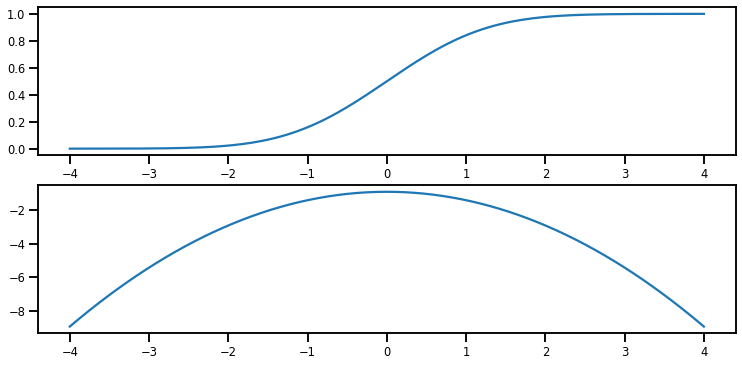

In [20]:
normal_cdf = tfb.NormalCDF()
x = np.linspace(-4, 4, 200)

plt.figure(figsize=(12.5, 6))
plt.subplot(211)
plt.plot(x, normal_cdf.forward(x))

plt.subplot(212)
plt.plot(x, normal_cdf.forward_log_det_jacobian(x, event_ndims=0))

### A bijector transforming a distribution

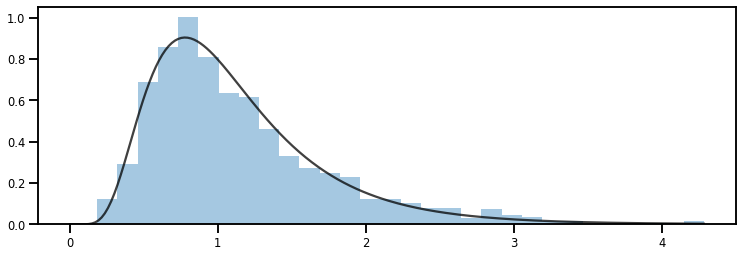

In [21]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))

samples = log_normal.sample(1000)

plt.figure(figsize=(12.5, 4))
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)

### Batching Bijectors

(200, 3)


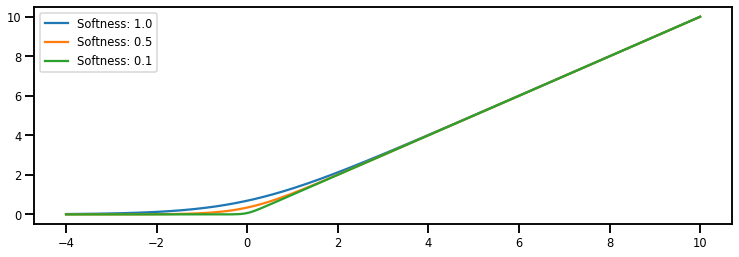

In [22]:
hinge_softness=[1., .5, .1]
softplus = tfb.Softplus(hinge_softness)
x = np.linspace(-4, 10, 200).reshape(-1, 1)
y = softplus.forward(x)
print(y.shape)

plt.figure(figsize=(12.5, 4))
for i in range(len(hinge_softness)):
    plt.plot(x, y[:, i], label=f"Softness: {hinge_softness[i]}")
plt.legend()

### Caching

In [23]:
# This bijector represents a matrix outer product on the forward pass,
# and a cholesky decomposition on the inverse pass. The latter costs O(N^3)!
bij = tfb.CholeskyOuterProduct()
size = 2500
# Make a big, lower-triangular matrix
big_lower_triangular = tf.eye(size)
# Squaring it gives us a positive-definite matrix
big_positive_definite = bij.forward(big_lower_triangular)

In [24]:
%timeit -r 5 -n 5 tf.linalg.cholesky(big_positive_definite)

9.79 ms ± 664 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [25]:
# Caching for the win!
%timeit -r 5 -n 5 bij.inverse(big_positive_definite)

30.3 µs ± 6.21 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


## MCMC

### Generate a data set

In [27]:
def f(x, w):
    x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
    linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
    result = linop.matmul(x, adjoint=True)
    return result[..., 0, :]

In [28]:
num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])

xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w).numpy() + np.random.normal(0, noise_scale, size=num_examples)

In [29]:
grid = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
xs_grid = np.vstack(grid)  # 200 * 100
fs_grid = f(xs_grid.reshape(num_features, -1), true_w).numpy().reshape(100, 100)

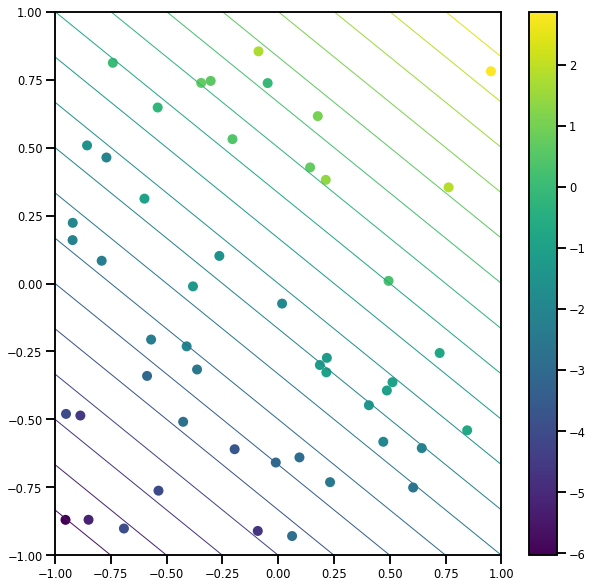

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(*xs, c=ys, s=100, linewidths=0)
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)

### Define our joint log-prob function

In [49]:
def joint_log_prob(w, x, y):
    """
    w ~ MVN([0, 0, 0], [1, 1, 1])
    yi ~ N(w @ xi, noise_scale)  i = 1, 2, ..., N
    """
    rv_w = tfd.MultivariateNormalDiag(loc=np.zeros(num_features + 1), scale_diag=np.ones(num_features + 1))
    rv_y = tfd.Normal(f(x, w), noise_scale)
    return rv_w.log_prob(w) + tf.reduce_sum(rv_y.log_prob(y), axis=-1)


def unnormalized_posterior(w):
    return joint_log_prob(w, xs, ys)

### Build HMC TransitionKernel and call `sample_chain`

In [50]:
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior, step_size=0.1, num_leapfrog_steps=2)

@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results, 
        num_burnin_steps=num_burnin_steps, 
        current_state=initial_state, kernel=hmc_kernel, 
        trace_fn=lambda current_state, kernel_results: kernel_results)

initial_state = np.zeros(num_features + 1)
samples, kernel_results = run_chain(initial_state)

In [51]:
print("Acceptance rate: ", kernel_results.is_accepted.numpy().mean())

Acceptance rate:  0.904


> That's not great! We'd like an acceptance rate closer to .65.

### Adaptive step sizes

In [55]:
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=int(0.8 * num_burnin_steps),
        target_accept_prob=np.float64(0.65)  # important
    )
    return tfp.mcmc.sample_chain(
        num_results=num_results, 
        num_burnin_steps=num_burnin_steps, 
        current_state=initial_state, kernel=adaptive_kernel, 
        trace_fn=lambda current_state, kernel_results: kernel_results)

samples, kernel_results = run_chain(initial_state)

In [59]:
print("Acceptance: ", kernel_results.inner_results.is_accepted.numpy().mean())

Acceptance:  0.565


(0.0, 6.0818376764578455)

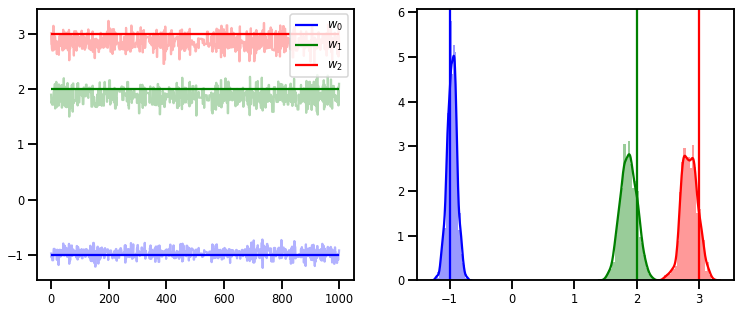

In [62]:
# trace plots
samples = samples.numpy()
plt.figure(figsize=(12.5, 5))
colors = ["blue", "green", "red"]

plt.subplot(121)
for i in range(3):
    plt.plot(samples[:, i], alpha=0.3, color=colors[i])
    plt.hlines(true_w[i], 0, 1000, zorder=4, color=colors[i], label=f"$w_{i}$")
plt.legend(loc="upper right")

plt.subplot(122)
for i in range(3):
    sns.distplot(samples[:, i], color=colors[i])

ymax = plt.ylim()[1]
for i in range(3):
    plt.vlines(true_w[i], 0, ymax, color=colors[i])
plt.ylim(0, ymax)




### Diagnosis  
Trace plots are nice, but diagnostics are nicer!  
First we need to run multiple chains. This is as simple as giving a batch of initial_state tensors.

In [63]:
# Instead of a single set of initial w's, we create a batch of 8.
num_chains = 8
initial_state = np.zeros([num_chains, num_features + 1])

chains, kernel_results = run_chain(initial_state)
# chains: [1000, num_chains, 3]

In [67]:
r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance Rate: ", kernel_results.inner_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per latent variable): ", r_hat.numpy())

Acceptance Rate:  0.60825
R-hat diagnostic (per latent variable):  [1.00072769 1.00131201 1.00210623]


### Sampling the noise scale

In [84]:
def joint_log_prob(w, sigma, x, y):
    """
    w ~ MVN([0, 0, 0], [1, 1, 1])
    yi ~ N(w @ xi, noise_scale)  i = 1, 2, ..., N
    """
    rv_w = tfd.MultivariateNormalDiag(loc=np.zeros(num_features + 1), scale_diag=np.ones(num_features + 1))
    rv_sigma = tfd.LogNormal(np.float64(1.), np.float64(5.))
    rv_y = tfd.Normal(f(x, w), sigma[..., np.newaxis])
    return rv_w.log_prob(w) + rv_sigma.log_prob(sigma) + tf.reduce_sum(rv_y.log_prob(y), axis=-1)


# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w, sigma):
    return joint_log_prob(w, sigma, xs, ys)

# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(.1),
    num_leapfrog_steps=4)

transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc_kernel, 
    bijector=[tfb.Identity(), tfb.Invert(tfb.Softplus())]  # w, sigma
)


# Apply a simple step size adaptation during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        transformed_kernel,
        num_adaptation_steps=int(.8 * num_burnin_steps),
        target_accept_prob=np.float64(.75))

    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_kernel,
        trace_fn=lambda cs, kr: kr)
num_chains = 8
initial_state = [np.zeros([num_chains, num_features + 1]), 
                 0.54 * np.ones([num_chains], dtype=np.float64)]

chains, kernel_results = run_chain(initial_state)

In [85]:
r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance rate:", kernel_results.inner_results.inner_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per w variable):", r_hat[0].numpy())
print("R-hat diagnostic (sigma):", r_hat[1].numpy())

Acceptance rate: 0.696625
R-hat diagnostic (per w variable): [1.00045473 1.00089526 1.00180672]
R-hat diagnostic (sigma): 1.0158363780813247


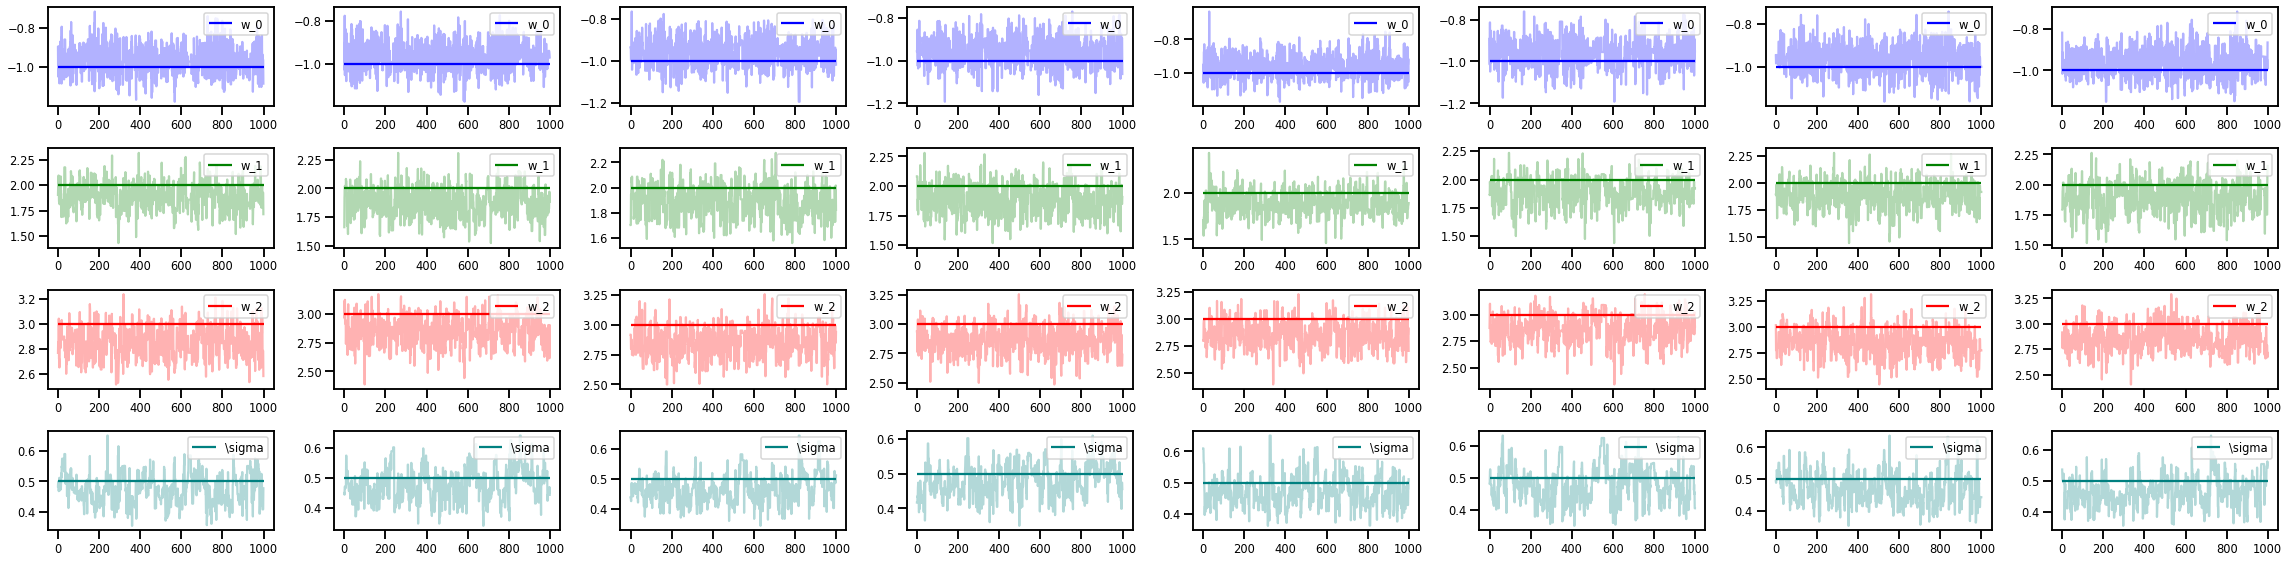

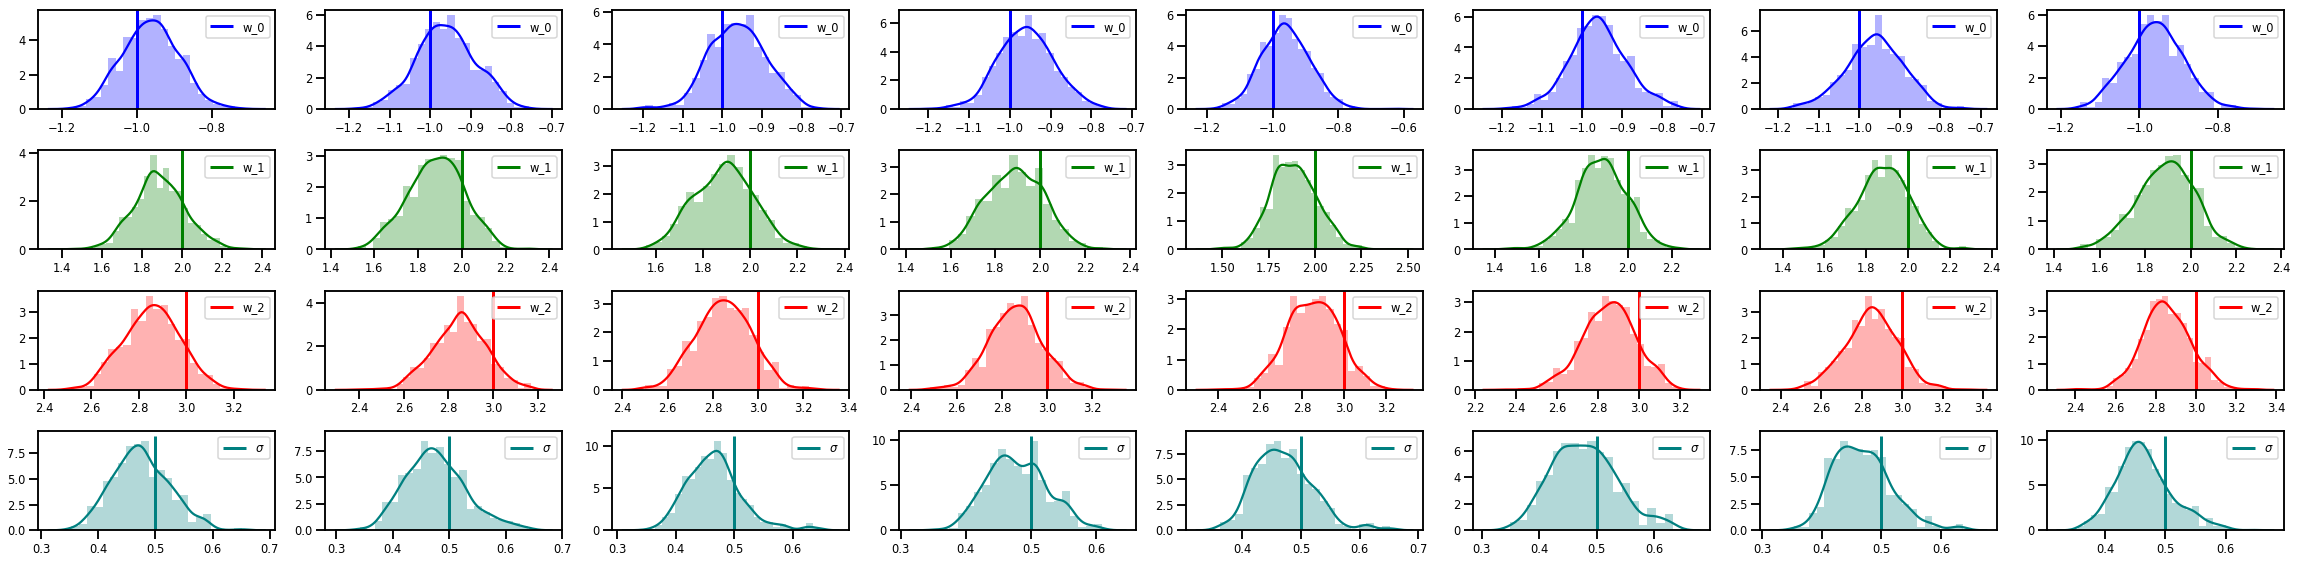

In [87]:
w_chains, sigma_chains = map(lambda x: x.numpy(), chains)
colors = ['b', 'g', 'r', 'teal']

# trace plot
fig, axes = plt.subplots(nrows=4, ncols=num_chains, figsize=(4 * num_chains, 8))
for i in range(num_chains):
    for j in range(3):
        ax = axes[j, i]
        ax.plot(w_chains[:, i, j], color=colors[j], alpha=0.3)
        ax.hlines(true_w[j], 0, 1000, zorder=4, color=colors[j], label=f"w_{j}")
        ax.legend(loc="upper right")
    ax = axes[3, i]
    ax.plot(sigma_chains[:, i], alpha=0.3, color=colors[3])
    ax.hlines(noise_scale, 0, 1000, zorder=4, color=colors[3], label=r"\sigma")
    ax.legend(loc="upper right")
fig.tight_layout()


# histogram plot
fig, axes = plt.subplots(nrows=4, ncols=num_chains, figsize=(4 * num_chains, 8))
for i in range(num_chains):
    for j in range(3):
        ax = axes[j, i]
        sns.distplot(w_chains[:, i, j], color=colors[j], ax=ax, norm_hist=True, hist_kws={"alpha": 0.3})
        
        ymax = ax.get_ylim()[1]
        ax.vlines(true_w[j], 0, ymax, color=colors[j], label=f"w_{j}", linewidth=3)
        ax.set_ylim(0, ymax)
        ax.legend(loc="upper right")
    
    ax = axes[3, i]
    sns.distplot(sigma_chains[:, i], color=colors[3], ax=ax, norm_hist=True, hist_kws={"alpha": 0.3})
    ymax = ax.get_ylim()[1]
    ax.vlines(noise_scale, 0, ymax, color=colors[3], label=r"$\sigma$", linewidth=3)
    ax.legend(loc="upper right")
fig.tight_layout()